In [53]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal
from spectrum import *
from pylab import *
import pandas as pd

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

In [3]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out


In [4]:
binned_spectra = [
    [[],[],[],[]],#0-1
    [[],[],[],[]],#1-2
    [[],[],[],[]],#2-3
    [[],[],[],[]],#3-4
    [[],[],[],[]],#4-5
    [[],[],[],[]],#5-6
    [[],[],[],[]],#6-7
    [[],[],[],[]],#7-8
    [[],[],[],[]]#8-9
]

In [5]:
%%script false --no-raise-error
cmap = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
fig, axs = plt.subplots(1,1)
failed = []
for eq_no in range(0, len(eq_with_data[0:100])):
    eq_name = eq_with_data[eq_no]
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
        #data.plot()
        inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
        data.remove_response(inv)
        with open(root+eq_name+'/picks.pkl', 'rb') as f:
            picks = pickle.load(f)
    except: 
        break
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            try:
                sr = data[tr_no].stats.sampling_rate
                tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
                #print(tr_name)
                pick = UTCDateTime(picks[tr_name])
                start = pick #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 4 # int(start + 4 * sr)
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.interpolate(100, 'lanczos', a = 20)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                coda = d.trim(start, end)
                coda.detrend()
                #plt.plot(coda)
                good = 'y'# input()
                if good.lower()[0]=='y':
                    dt = d.stats.delta

                    #creating the frequencies to plot on x axis 
                    Pfreq  = scipy.fft.rfftfreq(len(coda),dt)

                    #doing the multitaper to get the spectra 
                    N = len(coda)
                    NW=0.01*N
                    k=25
                    [tapers, eigen] = dpss(N, NW, k)
                    for eigen_no in range(0, len(eigen)):
                        if eigen[eigen_no] <= 0.5:
                            k = eigen_no
                            break
                    [tapers, eigen] = dpss(N, NW, k)

                    #print(eigen)
                    freq_complex, weights, eigenvalues=pmtm(coda, e=eigen, v=tapers, show=False)
                    freq = abs(freq_complex)
                    freq = np.mean(freq,axis =0)
                    freq_sdv = np.std(freq,axis =0)

                    dist = util.calc_hypo_dist(cat_with_data[eq_no], d, inv)
                    mag = cat_with_data[eq_no].magnitudes[0].mag
                    binned_spectra[int(np.round(mag, 0))][int(dist//50)].append([Pfreq[:-1],freq[0:N//2]])

                    #plotting the spectra in loglog
                    #print('plot')
                    if successful == 0:
                        axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), alpha = 0.5, label=str(cat_with_data[eq_no].magnitudes[0].mag), color = cmap[eq_no])#tr_name + data[tr_no].stats.channel)
                    #plt.fill_between(Pfreq[:-1],(Sk+Sk_sdv)[0:N//2],(Sk-Sk_sdv)[0:N//2],alpha=0.2)
                        axs.set_xlabel('Frequency (Hz)');
                        axs.set_ylabel('A^2');
                    #plt.title(tr_name + data[tr_no].stats.channel+' coda wave Power spectra');
                    #else:
                        #axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), color = cmap[eq_no], alpha = 0.5)#tr_name + data[tr_no].stats.channel)

                    Pfreq_MHZ = Pfreq
                    freq_MHZ = freq 
                    successful += 1
                else:
                    failed.append([eq_name, tr_name])
            #print(freq_MHZ.shape)
            #plt.show()
            except:
                failed.append([eq_name, tr_name])
axs.legend();
#axs.set_title('M'+str(cat_with_data[eq_no].magnitudes[0].mag) + ' ' + eq_name)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlim(0.5, 50)
#plt.close()


NameError: name 'tpmax' is not defined

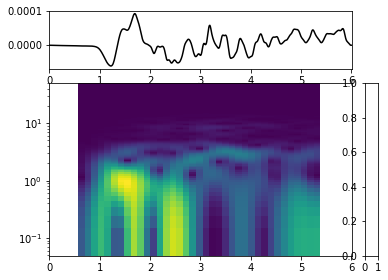

In [72]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

#make time vector
t = np.arange(d.stats.npts) / d.stats.sampling_rate

#plot waveform (top subfigure)    
ax1.plot(t, d.data, 'k')

spl2 = d
fig = spl2.spectrogram(show=False, axes=ax2, log=True)
mappable = ax2.collections[0]
ax2.hlines(tpmax, 0, 6, color='white')
ax2.hlines(tc, 0, 6, color='white')
plt.colorbar(mappable=mappable, cax=ax3)

In [56]:
pwd

'/home/earthquakes1/homes/Rebecca/phd/seismo_det/code'

In [57]:
df =  pd.read_pickle('/home/earthquakes1/homes/Rebecca/phd/seismo_det/dataframe.pkl')

In [63]:
df.__dict__

{'_attrs': {},
 '_flags': <Flags(allows_duplicate_labels=True)>,
 '_metadata': [],
 '_mgr': BlockManager
 Items: Index(['magnitude', 'tpmax', 'tc'], dtype='object')
 Axis 1: Index(['20190131_194949.a', '20190131_130953.a', '20190131_130350.a',
        '20190131_101656.a', '20190131_085520.a', '20190131_082011.a',
        '20190131_054201.a', '20190131_044030.a', '20190131_035250.a',
        '20190131_031714.a',
        ...
        '20190711_021721.a', '20190710_225713.a', '20190710_222949.a',
        '20190710_210705.a', '20190710_204027.a', '20190710_201915.a',
        '20190710_194859.a', '20190710_194552.a', '20190710_145814.a',
        '20190710_121608.a'],
       dtype='object', length=2867)
 NumericBlock: slice(0, 1, 1), 1 x 2867, dtype: float64
 ObjectBlock: slice(1, 3, 1), 2 x 2867, dtype: object,
 '_typ': 'dataframe',
 '_item_cache': {}}

In [70]:
df.loc['20190131_194949.a'].tc[0]

0.2682018971852354

20190131_194949.a
CX.HMBCX.
CX.HMBCX.
CX.HMBCX.
pick
d
CX.PB01.
CX.PB01.
CX.PB01.
pick
d
CX.PB08.
CX.PB08.
CX.PB08.
pick
d
20190131_130953.a
TC.RAFA.
TC.RAFA.
TC.RAFA.
pick
d
20190131_130350.a
XO.WD46.
XO.WD46.
XO.WD46.
pick
except
XO.WD54.
XO.WD54.
XO.WD54.


IndexError: list index out of range

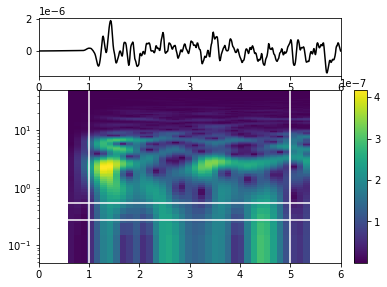

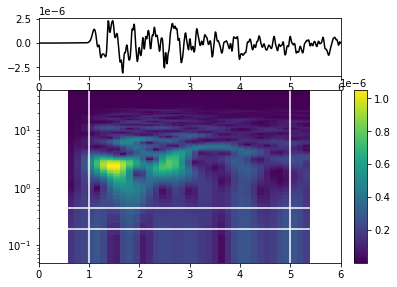

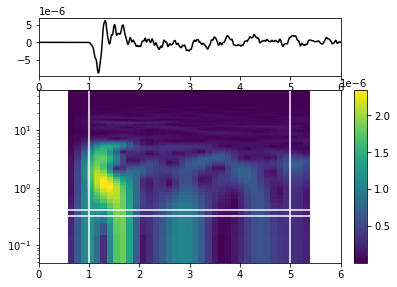

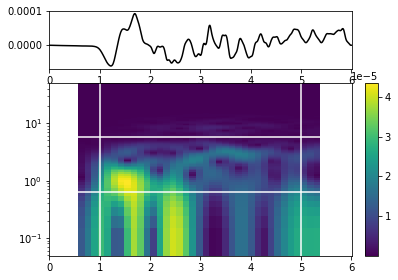

In [73]:
import random 
for count in range(0, 5):#len(eq_with_data[0:100])):
    eq_no = count #random.randrange(0,len(eq_with_data))
    eq_name = eq_with_data[eq_no]
    Z_comp = 0
    print(eq_name)
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
        #data.plot()
        inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
        data.remove_response(inv)
        with open(root+eq_name+'/picks.pkl', 'rb') as f:
            picks = pickle.load(f)
        df_row = df.loc[eq_name]
    except: 
        break
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            sr = data[tr_no].stats.sampling_rate
            tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
            print(tr_name)
            # only consider vertical stations (Z)
            if data[tr_no].stats.channel[-1] == 'Z':
                tpmax = df_row.tpmax[Z_comp]
                tc = df_row.tc[Z_comp]
                try:
                    print('pick')
                    pick = UTCDateTime(picks[tr_name])
                    start = pick -1 #int((pick - data[tr_no].stats.starttime)*sr)
                    end = pick + 5 # int(start + 4 * sr)
                    print('d')
                    d = data[tr_no].copy()#.filter('lowpass', freq=10)
                    d.interpolate(100, 'lanczos', a = 20)
                    d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                    d.detrend()
                    d.integrate()
                    d.detrend()
                    d.trim(start, end)
                    d.detrend()
                    from obspy.imaging.spectrogram import spectrogram
                    fig = plt.figure()
                    ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
                    ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
                    ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

                    #make time vector
                    t = np.arange(d.stats.npts) / d.stats.sampling_rate

                    #plot waveform (top subfigure)    
                    ax1.plot(t, d.data, 'k')

                    #plot spectrogram (bottom subfigure)
                    spl2 = d
                    fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                    mappable = ax2.collections[0]
                    ax2.vlines(1, 0, 50, color='white')
                    ax2.vlines(5, 0, 50, color='white')
                    ax2.hlines(tpmax, 0, 6, color='white')
                    ax2.hlines(tc, 0, 6, color='white')
                    plt.colorbar(mappable=mappable, cax=ax3)
                except:
                    print('except')
                Z_comp += 1

In [75]:
df_row

magnitude                     4.1
tpmax              [820.61685423]
tc           [0.4349646099634537]
Name: 20190131_130350.a, dtype: object

In [76]:
data

6 Trace(s) in Stream:
XO.WD46..HH1 | 2019-01-31T12:58:50.895500Z - 2019-01-31T13:08:50.885500Z | 100.0 Hz, 60000 samples
XO.WD46..HH2 | 2019-01-31T12:58:50.895501Z - 2019-01-31T13:08:50.885501Z | 100.0 Hz, 60000 samples
XO.WD46..HHZ | 2019-01-31T12:58:50.895500Z - 2019-01-31T13:08:50.885500Z | 100.0 Hz, 60000 samples
XO.WD54..HH1 | 2019-01-31T12:58:50.899700Z - 2019-01-31T13:08:50.889700Z | 100.0 Hz, 60000 samples
XO.WD54..HH2 | 2019-01-31T12:58:50.899700Z - 2019-01-31T13:08:50.889700Z | 100.0 Hz, 60000 samples
XO.WD54..HHZ | 2019-01-31T12:58:50.899700Z - 2019-01-31T13:08:50.889700Z | 100.0 Hz, 60000 samples

In [14]:
data[tr_no].stats.channel[-1]

'Z'